In [24]:
!pip install datasets



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
from datasets import load_dataset

dataset = load_dataset("mteb/stsbenchmark-sts")
train_data = dataset["train"]
test_data = dataset["test"]

In [25]:
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.metrics import mean_squared_error

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)

optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.MSELoss()

model.train()
for epoch in range(10):
    total_loss = 0
    for batch in DataLoader(train_data, batch_size=32, shuffle=True):
        inputs = tokenizer(batch["sentence1"], batch["sentence2"], padding=True, truncation=True, return_tensors="pt")
        labels = torch.tensor(batch["score"], dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(**inputs)
        logits = outputs.logits.squeeze()
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_data)
    print(f"Epoch {epoch+1}/{3}, Average Loss: {avg_loss:.4f}")

model.eval()
predictions = []
actual_scores = []

for batch in DataLoader(test_data, batch_size=32):
    inputs = tokenizer(batch["sentence1"], batch["sentence2"], padding=True, truncation=True, return_tensors="pt")
    labels = torch.tensor(batch["score"], dtype=torch.float)
    
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits.squeeze()
    predictions.extend(logits.tolist())
    actual_scores.extend(labels.tolist())

predicted_scores = [round(score, 2) for score in predictions]

print("Predicted   |   Actual")
for pred, actual in zip(predicted_scores[:10], actual_scores[:10]):
    print(f"{pred:.2f}        |   {actual}")

mse = mean_squared_error(actual_scores, predicted_scores)
print(f"Mean Squared Error: {mse:.4f}")


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.

Epoch 1/3, Average Loss: 0.0382
Epoch 2/3, Average Loss: 0.0152
Epoch 3/3, Average Loss: 0.0086
Epoch 4/3, Average Loss: 0.0056
Epoch 5/3, Average Loss: 0.0043
Epoch 6/3, Average Loss: 0.0036
Epoch 7/3, Average Loss: 0.0032
Epoch 8/3, Average Loss: 0.0026
Epoch 9/3, Average Loss: 0.0024
Epoch 10/3, Average Loss: 0.0021


/var/folders/9f/7hhtd_4d75sc0w7x26jq14hh0000gn/T/ipykernel_5385/2539674963.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch["score"], dtype=torch.float)


Predicted   |   Actual
3.19        |   2.5
3.54        |   3.5999999046325684
4.88        |   5.0
4.90        |   4.199999809265137
2.22        |   1.5
1.90        |   1.7999999523162842
3.32        |   3.5
1.65        |   2.200000047683716
2.06        |   2.200000047683716
1.80        |   1.7139999866485596
Mean Squared Error: 0.7397


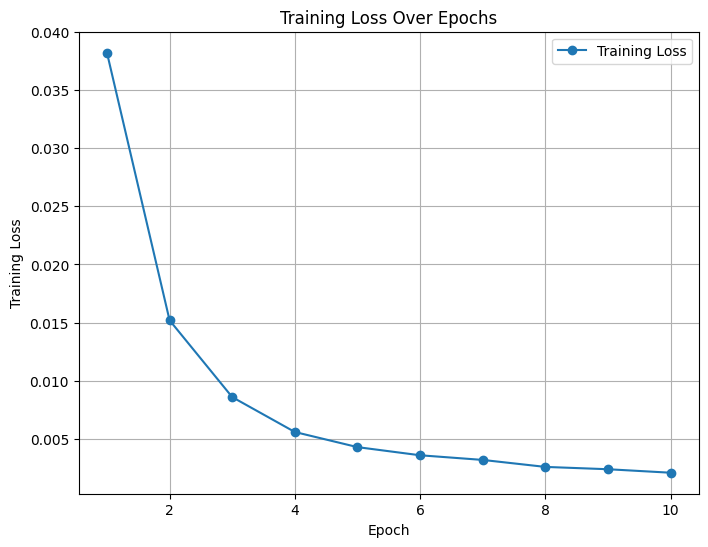

In [1]:
import matplotlib.pyplot as plt

train_losses = [0.0382, 0.0152, 0.0086, 0.0056, 0.0043, 0.0036, 0.0032, 0.0026, 0.0024, 0.0021]

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [26]:
model.save_pretrained("fine_tuned_distilbert_sts")


In [3]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import mean_squared_error

model = DistilBertForSequenceClassification.from_pretrained("fine_tuned_distilbert_sts")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
predictions = []
actual_scores = []

for batch in DataLoader(test_data, batch_size=32):
    inputs = tokenizer(batch["sentence1"], batch["sentence2"], padding=True, truncation=True, return_tensors="pt")
    labels = torch.tensor(batch["score"], dtype=torch.float)
    
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits.squeeze()
    predictions.extend(logits.tolist())
    actual_scores.extend(labels.tolist())

predicted_scores = [round(score, 2) for score in predictions]

print("Predicted   |   Actual")
for pred, actual in zip(predicted_scores[:10], actual_scores[:10]):
    print(f"{pred:.2f}        |   {actual}")



/var/folders/9f/7hhtd_4d75sc0w7x26jq14hh0000gn/T/ipykernel_1622/3168219336.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch["score"], dtype=torch.float)


Predicted   |   Actual
3.19        |   2.5
3.54        |   3.5999999046325684
4.88        |   5.0
4.90        |   4.199999809265137
2.22        |   1.5
1.90        |   1.7999999523162842
3.32        |   3.5
1.65        |   2.200000047683716
2.06        |   2.200000047683716
1.80        |   1.7139999866485596


In [5]:
from scipy.stats import pearsonr

pearson_corr, _ = pearsonr(predicted_scores, actual_scores)
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")


Pearson Correlation Coefficient: 0.8260


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.we

Epoch 1/10, Average Loss: 0.0366
Epoch 2/10, Average Loss: 0.0143
Epoch 3/10, Average Loss: 0.0078
Epoch 4/10, Average Loss: 0.0056
Epoch 5/10, Average Loss: 0.0042
Epoch 6/10, Average Loss: 0.0033
Epoch 7/10, Average Loss: 0.0027
Epoch 8/10, Average Loss: 0.0023
Epoch 9/10, Average Loss: 0.0023
Epoch 10/10, Average Loss: 0.0023


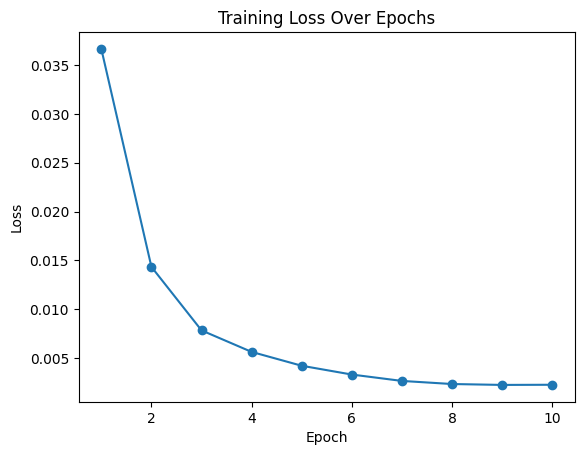

/var/folders/9f/7hhtd_4d75sc0w7x26jq14hh0000gn/T/ipykernel_1622/778553159.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch["score"], dtype=torch.float)


Predicted   |   Actual
3.69        |   2.5
4.19        |   3.5999999046325684
4.90        |   5.0
4.96        |   4.199999809265137
1.85        |   1.5
1.76        |   1.7999999523162842
3.58        |   3.5
1.50        |   2.200000047683716
2.33        |   2.200000047683716
1.59        |   1.7139999866485596
Mean Squared Error: 0.7448


In [4]:
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)

optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.MSELoss()

model.train()
loss_values = []

for epoch in range(10):
    total_loss = 0
    for batch in DataLoader(train_data, batch_size=32, shuffle=True):
        inputs = tokenizer(batch["sentence1"], batch["sentence2"], padding=True, truncation=True, return_tensors="pt")
        labels = torch.tensor(batch["score"], dtype=torch.float)

        optimizer.zero_grad()

        outputs = model(**inputs)
        logits = outputs.logits.squeeze()

        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_data)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch+1}/10, Average Loss: {avg_loss:.4f}")
plt.plot(range(1, 11), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

model.eval()
predictions = []
actual_scores = []

for batch in DataLoader(test_data, batch_size=32):
    inputs = tokenizer(batch["sentence1"], batch["sentence2"], padding=True, truncation=True, return_tensors="pt")
    labels = torch.tensor(batch["score"], dtype=torch.float)
    
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits.squeeze()
    predictions.extend(logits.tolist())
    actual_scores.extend(labels.tolist())


In [5]:
model.save_pretrained("fine_tuned_sts")


In [6]:
from scipy.stats import pearsonr

pearson_corr, _ = pearsonr(predicted_scores, actual_scores)
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")


Pearson Correlation Coefficient: 0.8286
